## Análisis preliminar de datos

A continuación se presenta un primer análisis de los datos censales correspondientes a 2011.

In [3]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely.geometry import shape, LineString

In [37]:
# carga datos desde GitHub

# Datos censales
censo = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip',
                    compression='zip', header=0, sep=',', quotechar='"')

# PBI departamental
pbi = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/pbi_departamental.csv')

# matriz de distancias
capitales_md = pd.read_csv('https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/df_distancias_google.csv')

# carga capa departamentos INE pg
deptos = gpd.read_file('https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_deptos.gpkg')

# carga capa localidades INE pt
localidad = gpd.read_file('https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_localidades.gpkg')
localidad.CODLOC = localidad.CODLOC.astype(int)

# filtra capitales departamentales de las localidades INE
capital = localidad[localidad.CAPITAL==True].reset_index(drop=True)

In [46]:
# calcula la población de cada departamento
poblacion = censo[['DPTO', 'LOC']].groupby(by=['DPTO']).count()
poblacion.rename(columns={'LOC': 'poblacion'}, inplace=True)

# genera dataframe con datos por departamento
datos_dpto = pd.merge(pbi, poblacion, on='DPTO')

In [47]:
# recupera el depto de la matriz de distancias
capital_cods = capital[['DEPTO','CODLOC']]

deptos_md = pd.merge(capitales_md, capital_cods, left_on='cod_ori', right_on='CODLOC')
deptos_md = pd.merge(deptos_md, capital_cods, left_on='cod_des', right_on='CODLOC')

deptos_md.rename(columns={'DEPTO_x': 'depto_ori', 'DEPTO_y': 'depto_des'}, inplace=True)
deptos_md.drop(['latlon_ori', 'latlon_des', 'cod', 'CODLOC_x', 'CODLOC_y'], axis=1, inplace=True)

# genera un codigo de diada unico, de 4 digitos (para evitar que 11+2 = 1+12... quedarian 1102 y 0112)
deptos_md['cod_diada'] = deptos_md['depto_ori'].astype(str).str.zfill(2) + deptos_md['depto_des'].astype(str).str.zfill(2)

# ambos números deberían coincidir
# print(len(pd.unique(deptos_md.cod_diada)))
# deptos_md.shape[0]

**Análisis por departamentos**

Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personal del Censo INE 2011 se filtra según el siguiente criterio:
Variable "PERMI07" (lugar de residencia 5 años antes) con valores 2 (en otra localidad o paraje de este departamento) o 3 (en otro departamento). Se excluye habitantes de localidades rurales.

In [48]:
# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# cambia DPTO a tipo entero
p_migr.DPTO = p_migr.DPTO.astype(int)

print(p_migr.shape[0])

# Hay 26.449 residentes en localidades rurales
print(p_migr[( p_migr.LOC == 900 )].shape[0])

215899
26449


In [49]:
# identifica depto de residencia anterior
p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')]
p_migr.depto_origen.fillna(p_migr.DPTO, inplace=True)

# convierte a string
p_migr.loc[:,('depto_origen')] = p_migr.loc[:,('depto_origen')].astype(int)

# renombra DPTO
p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

p_migr.head()

,depto_destino,LOC,SECC,SEGM,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,3,NaN,3.0,732.0,0,3
40,1,20,1,1,3,NaN,17.0,220.0,0,17
50,1,20,1,1,3,NaN,18.0,220.0,0,18
64,1,20,1,1,3,NaN,2.0,220.0,0,2
110,1,20,1,1,3,NaN,12.0,320.0,0,12


In [50]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

In [51]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos, index ='depto_origen', columns='depto_destino', fill_value=0,
                        aggfunc=sum, margins=True, margins_name='Total',)
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [62]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo unico
df_agrupado.insert(0, 'cod_diada', df_agrupado['depto_origen'].astype(str).str.zfill(2)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2))

merge1 = pd.merge(df_agrupado, datos_dpto[['DPTO', 'miles_de_pesos', 'poblacion']], left_on='depto_origen', right_on='DPTO')
merge2 = pd.merge(merge1, datos_dpto[['DPTO', 'miles_de_pesos', 'poblacion']], left_on='depto_destino', right_on='DPTO')
merge3 = pd.merge(merge2, deptos_md[['cod_diada', 'distancia']], on='cod_diada')
datos_diadas = merge3.drop(['DPTO_x', 'DPTO_y'], axis=1)

del(merge1, merge2, merge3)

datos_diadas.rename(columns={'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino',
                             'distancia': 'dist', 'poblacion_x': 'pob_origen', 'poblacion_y': 'pob_destino'},
                    inplace=True)

datos_diadas.head()

,cod_diada,depto_origen,depto_destino,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist
0,0102,1,2,914,465848031,1318755,14214980,73377,575727
1,0302,3,2,74,86306492,520173,14214980,73377,539024
2,0402,4,2,15,17048887,84698,14214980,73377,356548
3,0502,5,2,28,43788749,123203,14214980,73377,571901
4,0602,6,2,32,13023942,57084,14214980,73377,400851


Text(0.5, 0, 'Distancias (m)')

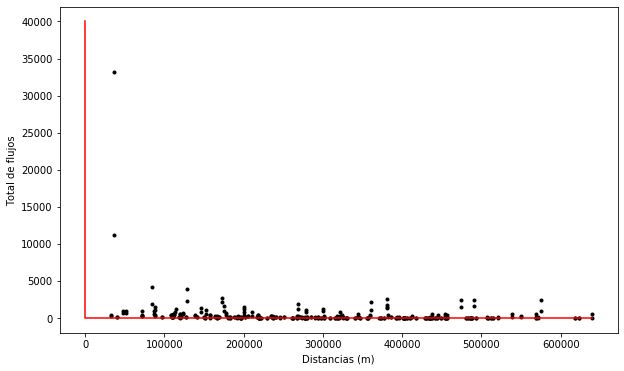

In [63]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.005, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals,yvals,color='r')

# Aetiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancias (m)")

Text(0.5, 0, 'Origin Population')

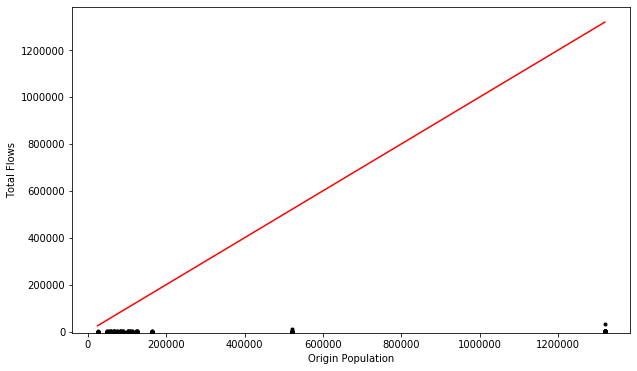

In [67]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['pob_origen'], datos_diadas['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pob_origen'].min(), datos_diadas['pob_origen'].max(),100)
yvals = np.power(xvals,1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, datos_diadas['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Origin Population")

Text(0.5, 0, 'PBI en destino')

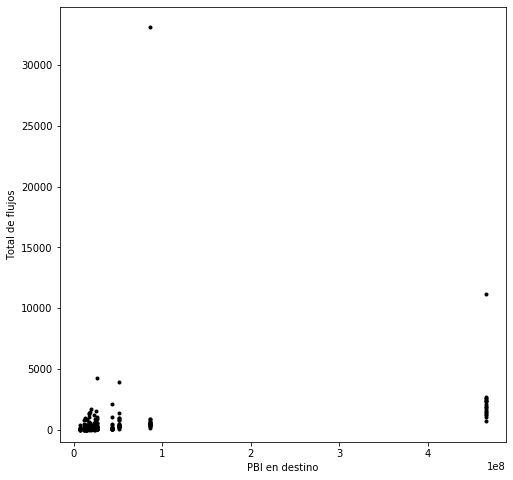

In [69]:
# Plot dePBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(datos_diadas['pbi_destino'], datos_diadas['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pbi_destino'].min(), datos_diadas['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, datos_diadas['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

In [37]:
# Run a production constrained SIM using a Poisson GLM.
# We'll do this using statsmodels, and the formula approach.
# Here we're just using the 7 borough sub sample of data.
# First take logs of the relevant fields

# destsal es el salario medio en destuno
# vamos a usar el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))
# logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))

Ejemplo de modelo con restricción en el origen

In [38]:
# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.

formula = "personas_mig ~ depto_origen + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      339
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81274.
Date:                Wed, 27 May 2020   Deviance:                   1.6032e+05
Time:                        12:29:44   Pearson chi2:                 2.42e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
depto_origen       -0.1408      0.001   -233.458      0.000      -0.142      -0.140
log_pbi_destino     0.8653      0.001    736.389      0.000       0.863       0.868
log_dist           -0.6600      0.002   -354.515      0.000      -0.664      -0.656
===================================================================================
"""

So, what do we have from this model?

The $\alpha$ parameter related to destination attractiveness is 0.8653

The $\beta$ distance decay parameter is -0.66

The 'coef' for each origin (given here as OrigNewCode[code]) is the logged $A_{i}O_{i}$ value for that origin.